# Objectives
For questions 1,2,3 and 4 use the train.csv dataset. For question 5 you should use the dataset 'train.csv' and 'test_X.csv'.

    1.    What are the 3 countries where most orders are placed?
    2.    What are the hours when most orders are placed in Spain?
    3.    What is the average price per order in the store with ID 12513?
    4.    Taking into account the peaks of demand in Spain, if the delivery drivers work in 8-hour shifts.
        Shift 1 (00:00-08:00)
        Shift 2 (08:00-16:00)
        Shift 3 (16:00-00:00)

        What percentage of delivery drivers would you allocate for each shift to cope with peak demand (e.g. Shift 1 30%, Shift 2 10% and Shift 3 60%)?

    5.    Perform a predictive machine learning model of the 'train.csv' dataset using the predictor variables delivered in the 'test_X' dataset that will predict whether the order will be cancelled or not ('final_status' column).

For simplicity, you can assign the 'CanceledStatus' values to 0 and the 'DeliveredStatus' values to 1.

0 = CanceledStatus
1 = DeliveredStatus

Deliver the predictions in a separate csv. As can be seen in the 'example_predictions' example. The quality of the prediction will be measured by the f1-score(macro)

In [64]:
# Importing libraries for:
# Data processing
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Plots
# ------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (25,16) 

# Stats
# ------------------------------------------------------------------------
import sidetable

# Times and dates
# ------------------------------------------------------------------------
import datetime as dt
from datetime import datetime

In [2]:
# Loading a dataframe

df = pd.read_csv('data/train.csv')
df.head()

,order_id,local_time,country_code,store_address,payment_status,n_of_products,products_total,final_status
0,33446280,14:11:09,AR,55379,PAID,2,11.88,DeliveredStatus
1,33107339,11:47:41,GT,23487,PAID,2,5.20,DeliveredStatus
2,32960645,11:53:53,CR,62229,PAID,1,6.03,DeliveredStatus
3,32089564,20:15:21,ES,29446,PAID,6,6.37,DeliveredStatus
4,32157739,21:32:16,AR,13917,PAID,1,5.36,CanceledStatus


In [3]:
# Checking shape, info and main statistical attributes

df.shape

(54330, 8)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54330 entries, 0 to 54329
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   order_id        54330 non-null  int64  
 1   local_time      54330 non-null  object 
 2   country_code    54330 non-null  object 
 3   store_address   54330 non-null  int64  
 4   payment_status  54330 non-null  object 
 5   n_of_products   54330 non-null  int64  
 6   products_total  54330 non-null  float64
 7   final_status    54330 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 3.3+ MB


In [4]:
# For numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_id,54330.0,3.278267e+07,445940.244923,31503775.0,32400066.75,32781587.50,33183798.00,33560846.00
store_address,54330.0,4.160938e+04,21903.267141,190.0,21369.00,45993.50,62004.00,75236.00
n_of_products,54330.0,2.815792e+00,2.430936,1.0,1.00,2.00,3.00,39.00
products_total,54330.0,9.838136e+00,9.260352,0.0,4.13,7.13,12.77,221.48


> * We can conclude that order_id and store_address are in fact categorical variables.
> * Normally people buy 2 products per order, although there is a maximum of 39 (check outliers)
> * There is a minimum order total cost of 0€ (check how often this happens) although the most usual total cost is of around 7€


In [8]:
# For categorical variables
df.describe(include='O').T

,count,unique,top,freq
local_time,54330,32905,09:03:01,38
country_code,54330,23,AR,11854
payment_status,54330,3,PAID,53854
final_status,54330,2,DeliveredStatus,48498


> * The most common order time is exactly 9:03:01
> * The most frequent country in this dataset is Argentina
> * Only `10.73%` of orders have a Cancelled Status --> (5832 out of 54330)

In [6]:
# Checking nulls

df.isnull().sum()

order_id          0
local_time        0
country_code      0
store_address     0
payment_status    0
n_of_products     0
products_total    0
final_status      0
dtype: int64

` 1.    What are the 3 countries where most orders are placed?` 

In [10]:
df['country_code'].value_counts()

AR    11854
ES    11554
TR     5696
PE     4284
UA     3729
IT     2537
EC     2265
RO     1957
FR     1911
EG     1643
MA     1446
CR     1000
CL      994
PA      909
PT      818
GT      511
GE      485
DO      448
UY      169
KE       84
PR       29
CI        6
BR        1
Name: country_code, dtype: int64

> Argentina (AR), Spain (ES) and Turkey (TR) are the three countries where most orders are placed

`2.    What are the hours when most orders are placed in Spain?` 

In [99]:
# First make a subset where the only country is Spain

spain = df[df['country_code']== 'ES']
spain.head()

,order_id,local_time,country_code,store_address,payment_status,n_of_products,products_total,final_status
3,32089564,20:15:21,ES,29446,PAID,6,6.37,DeliveredStatus
8,32236610,17:09:16,ES,30120,PAID,3,4.35,DeliveredStatus
13,32235607,18:02:18,ES,18682,PAID,9,16.12,DeliveredStatus
19,32670668,14:37:58,ES,8994,PAID,12,17.93,DeliveredStatus
24,32126718,21:12:30,ES,14872,PAID,3,22.00,DeliveredStatus


In [16]:
# Show the value counts for each local time

pd.options.display.max_rows=None
spain['local_time'].value_counts()

10:03:06    17
10:03:07    17
21:03:01    16
10:03:08    15
10:03:05    15
10:03:03    13
10:03:01    12
10:03:04    11
20:03:03     9
10:03:12     9
10:03:09     9
10:03:02     8
15:43:03     7
10:03:10     7
10:03:11     7
13:03:08     7
09:03:06     6
15:43:02     6
09:03:07     6
14:43:03     6
13:03:10     5
15:43:04     5
21:13:01     5
20:03:01     5
09:03:10     5
20:45:30     5
20:15:00     4
20:09:43     4
20:16:25     4
20:58:47     4
21:06:48     4
14:13:35     4
13:33:04     4
20:43:06     4
20:26:25     4
20:47:47     4
11:43:04     4
19:13:29     4
20:49:12     4
14:43:04     4
17:43:05     4
13:43:08     4
19:34:12     4
14:40:24     4
15:14:11     4
17:43:02     4
13:43:13     4
13:51:10     3
20:43:23     3
21:33:05     3
12:26:49     3
20:50:30     3
18:49:54     3
20:05:50     3
14:39:35     3
19:22:42     3
18:05:49     3
21:10:38     3
13:43:15     3
20:51:01     3
19:37:17     3
20:29:33     3
19:20:52     3
21:24:54     3
20:39:09     3
14:08:03     3
12:43:13  

In [39]:
# In a dataframe:
spaingr = spain.groupby(['local_time']).count().sort_values(by = 'order_id', ascending=False)
spaingr.head()

,order_id,country_code,store_address,payment_status,n_of_products,products_total,final_status
local_time,,,,,,,
10:03:07,17,17,17,17,17,17,17
10:03:06,17,17,17,17,17,17,17
21:03:01,16,16,16,16,16,16,16
10:03:05,15,15,15,15,15,15,15
10:03:08,15,15,15,15,15,15,15


> The most common hours for ordering products seem to be at around 10 AM and at around 9 PM. However, plotting this column will give us a more accurate idea

In [100]:
# Transforming the column dtype for plotting

spain.local_time = spain.local_time.astype("datetime64")
spain.head()


/tmp/ipykernel_818/477668250.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spain.local_time = spain.local_time.astype("datetime64")


,order_id,local_time,country_code,store_address,payment_status,n_of_products,products_total,final_status
3,32089564,2022-11-07 20:15:21,ES,29446,PAID,6,6.37,DeliveredStatus
8,32236610,2022-11-07 17:09:16,ES,30120,PAID,3,4.35,DeliveredStatus
13,32235607,2022-11-07 18:02:18,ES,18682,PAID,9,16.12,DeliveredStatus
19,32670668,2022-11-07 14:37:58,ES,8994,PAID,12,17.93,DeliveredStatus
24,32126718,2022-11-07 21:12:30,ES,14872,PAID,3,22.00,DeliveredStatus


In [87]:
# Checking new dtypes
spain.dtypes

order_id                   int64
local_time        datetime64[ns]
country_code              object
store_address              int64
payment_status            object
n_of_products              int64
products_total           float64
final_status              object
dtype: object

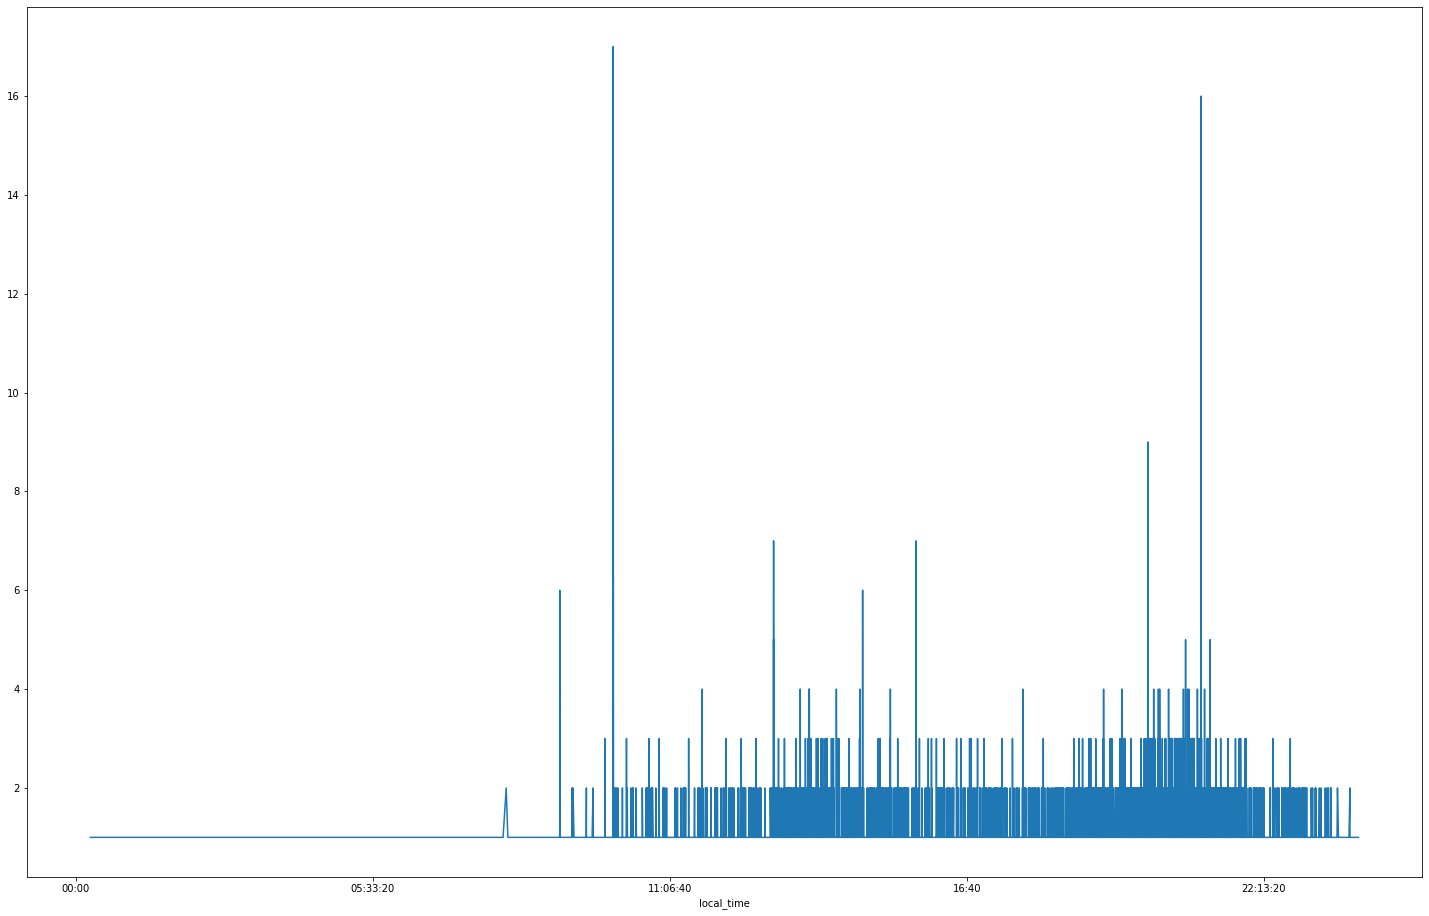

In [102]:
# Quick plotting to see the frequency of orders along time

spain.groupby(spain.local_time.dt.time).count()['order_id'].plot(kind="line");

> * We can confirm that the main peaks happen at around 10 AM and 21 PM
> * However, the most active time slots are middays and evenings

`3.    What is the average price per order in the store with ID 12513?`

In [58]:
# Let's filter

df[df['store_address'] == 12513]['products_total'].mean()

17.392244897959173

> The average price per order in the store with ID 12513 is of *`€17.4`*

`4. Taking into account the peaks of demand in Spain, if the delivery drivers work in 8-hour shifts.`

        Shift 1 (00:00-08:00)

        Shift 2 (08:00-16:00)
        
        Shift 3 (16:00-00:00)

`What percentage of delivery drivers would you allocate for each shift to cope with peak demand (e.g. Shift 1 30%, Shift 2 10% and Shift 3 60%)?`

In [ ]:
# I would answer this question by analyzing the percentage of orders that take place during these time shifts

In [89]:
shift1 = spain[(spain['local_time'] >= '00:00:00') & (spain['local_time'] <= '08:00:00')]
shift1.head()

,order_id,local_time,country_code,store_address,payment_status,n_of_products,products_total,final_status
3655,32756826,2022-11-07 00:39:03,ES,16337,PAID,4,18.95,DeliveredStatus
4252,32320402,2022-11-07 00:46:48,ES,16347,PAID,6,17.40,DeliveredStatus
6052,32497368,2022-11-07 00:26:08,ES,16348,NOT_PAID,5,6.45,DeliveredStatus
7365,32147971,2022-11-07 00:26:47,ES,16348,PAID,3,4.40,DeliveredStatus
7858,32499362,2022-11-07 00:42:33,ES,16347,PAID,1,2.95,CanceledStatus


In [69]:
shift2 = spain[(spain['local_time'] > '08:00:00') & (spain['local_time'] <= '16:00:00')]
shift2.head()

,order_id,local_time,country_code,store_address,payment_status,n_of_products,products_total,final_status
19,32670668,2022-11-07 14:37:58,ES,8994,PAID,12,17.93,DeliveredStatus
75,32039883,2022-11-07 15:29:14,ES,13660,PAID,6,45.90,DeliveredStatus
78,32528876,2022-11-07 10:40:44,ES,7777,PAID,3,13.65,DeliveredStatus
102,32796628,2022-11-07 14:06:42,ES,16245,PAID,21,33.33,CanceledStatus
121,33068237,2022-11-07 13:27:31,ES,29451,PAID,3,21.40,DeliveredStatus


In [71]:
shift3 = spain[(spain['local_time'] > '16:00:00') & (spain['local_time'] <= '23:59:59')]
shift3.head()

,order_id,local_time,country_code,store_address,payment_status,n_of_products,products_total,final_status
3,32089564,2022-11-07 20:15:21,ES,29446,PAID,6,6.37,DeliveredStatus
8,32236610,2022-11-07 17:09:16,ES,30120,PAID,3,4.35,DeliveredStatus
13,32235607,2022-11-07 18:02:18,ES,18682,PAID,9,16.12,DeliveredStatus
24,32126718,2022-11-07 21:12:30,ES,14872,PAID,3,22.00,DeliveredStatus
25,32229263,2022-11-07 16:13:48,ES,14872,PAID,1,15.00,DeliveredStatus


In [79]:
# Let's check the total of orders in Spain
print('Total orders in Spain are: ', spain.shape[0])

Total orders in Spain are:  11554


In [90]:
# Let's check if the sum of orders per shift coincides with the total
shift1.shape[0] + shift2.shape[0] + shift3.shape[0]

11554

In [93]:
# The percentage of orders according to each shift:

print('During shift 1:', round((shift1.shape[0]/spain.shape[0])*100, 2), '% of the orders take place')

During shift 1: 0.12 % of the orders take place


In [95]:
print('During shift 2:', round((shift2.shape[0]/spain.shape[0])*100, 2), '% of the orders take place')

During shift 2: 38.84 % of the orders take place


In [96]:
print('During shift 3:', round((shift3.shape[0]/spain.shape[0])*100, 2), '% of the orders take place')

During shift 3: 61.04 % of the orders take place


> I would allocate:
> * `0.12%` of the riders during the first shift
> * `38.84%` of the riders during the second shift
> * `61.04%` of the riders during the third shift

Outliers and other plots will be done in the 'outliers-and-distributions' notebook